# Neural Networks: Training with Backpropagation

## Recap: Forward Propagation

In the previous notebook (**16_neural_network_intro.ipynb**), we learned:
- The structure of a 2-layer neural network
- How forward propagation computes predictions
- The role of weights, biases, and activation functions

However, with randomly initialized weights, our predictions are essentially random! 
We need a way to **learn** the right weights from data.

## The Training Problem

**Goal**: Find weights and biases that minimize the difference between predictions and true labels.

**Process**:
1. **Measure error**: Use a loss function to quantify how wrong our predictions are
2. **Compute gradients**: Use backpropagation to calculate how each parameter affects the loss
3. **Update parameters**: Use gradient descent to adjust parameters in the direction that reduces loss
4. **Repeat**: Iterate until the loss converges to a minimum


In [5]:
# Import required libraries
from typing import Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


## Data Preparation

We'll use the same breast cancer dataset and preprocessing as in the previous notebook.


In [6]:
# Load and prepare the data
data = pd.read_csv(
    "https://raw.githubusercontent.com/changyaochen/MECE4520/master/"
    "data/breast_cancer.csv"
)
data["label"] = data["diagnosis"].apply(lambda x: 0 if x == "B" else 1)

# Select features
features = [
    "radius_mean",
    "texture_mean",
    "perimeter_mean",
    "area_mean",
    "smoothness_mean",
    "compactness_mean",
    "concavity_mean",
    "concave_mean",
    "symmetry_mean",
    "fractal_mean",
]

# Train-test split
X_raw, X_raw_test, y, y_test = train_test_split(
    data[features].values,
    data["label"].values,
    test_size=0.2,
    random_state=42
)

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X_raw)
X_test = scaler.transform(X_raw_test)

# Reshape labels
y = y.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

print(f"Training data: X={X.shape}, y={y.shape}")
print(f"Test data: X_test={X_test.shape}, y_test={y_test.shape}")


Training data: X=(455, 10), y=(455, 1)
Test data: X_test=(114, 10), y_test=(114, 1)


## Helper Functions

Let's (re-)define the sigmoid activation function and the forward propagation function from the previous notebook.


In [7]:
def sigmoid(z: np.ndarray) -> np.ndarray:
    """Computes the sigmoid activation function.

    Args:
        z: Input array of any shape.

    Returns:
        Array of same shape as z with sigmoid applied element-wise.
    """
    return 1.0 / (1 + np.exp(-z))


def forward_propagation(
    X: np.ndarray,
    W_1: np.ndarray,
    b_1: np.ndarray,
    W_2: np.ndarray,
    b_2: np.ndarray,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Performs forward propagation through a 2-layer neural network.

    Args:
        X: Input data of shape (n_samples, n_features).
        W_1: Weight matrix for layer 1 of shape (n_hidden, n_features).
        b_1: Bias vector for layer 1 of shape (n_hidden, 1).
        W_2: Weight matrix for layer 2 of shape (1, n_hidden).
        b_2: Bias scalar for layer 2 of shape (1, 1).

    Returns:
        Tuple containing:
            - A_2: Final output predictions of shape (n_samples, 1).
            - Z_2: Pre-activation values for layer 2 of shape (n_samples, 1).
            - A_1: Activations from layer 1 of shape (n_samples, n_hidden).
            - Z_1: Pre-activation values for layer 1 of shape (n_samples, n_hidden).
    """
    # Layer 1: Hidden layer
    Z_1 = X @ W_1.T
    A_1 = sigmoid(Z_1 + b_1.T)

    # Layer 2: Output layer
    Z_2 = A_1 @ W_2.T
    A_2 = sigmoid(Z_2 + b_2.T)

    return A_2, Z_2, A_1, Z_1


## Backpropagation Theory

### The Loss Function

For binary classification, we use **binary cross-entropy loss** (also called log-loss):

$$
L = -\frac{1}{n} \sum_{i=1}^{n} \left[ y_i \log(\hat{y}_i) + (1-y_i) \log(1-\hat{y}_i) \right],
$$

where $n$ is the number of samples, $y_i \in \{0, 1\}$ is the true label, and $\hat{y}_i$ is the predicted probability. This loss:
- Is always positive
- Equals 0 when predictions perfectly match labels
- Increases as predictions diverge from labels
- Works well with sigmoid activation

### The Chain Rule

Backpropagation uses the **chain rule** from calculus to compute how the loss changes with respect to each parameter. For a composed function $ f(g(x)) $, the chain rule states:

$$
\frac{df}{dx} = \frac{df}{dg} \cdot \frac{dg}{dx}
$$

In our network, information flows: **Input → Layer 1 → Layer 2 → Output → Loss**

To find how the loss changes with parameters in Layer 1, we need to propagate derivatives backward through Layer 2, Layer 1, and so on.

### Gradient Descent

Once we have gradients (derivatives of loss with respect to parameters), we update parameters using:

$$
\theta_{new} = \theta_{old} - \alpha \frac{\partial L}{\partial \theta}
$$

where $ \alpha $ is the **learning rate** (step size). The negative sign means we move in the direction that reduces the loss.


## Backpropagation Implementation

Now let's implement backpropagation to compute all the gradients. The key insight is to work **backward** from the output to the input.

### Gradient Equations (for our 2-layer network with sigmoid activation):

**Output layer (Layer 2):**
- $ \frac{\partial L}{\partial Z^{[2]}} = \hat{Y} - Y $  (derivative of cross-entropy + sigmoid)
- $ \frac{\partial L}{\partial W^{[2]}} = \frac{1}{n} \frac{\partial L}{\partial Z^{[2]}}^T A^{[1]} $
- $ \frac{\partial L}{\partial b^{[2]}} = \frac{1}{n} \text{mean}(\frac{\partial L}{\partial Z^{[2]}}) $

**Hidden layer (Layer 1):**
- $ \frac{\partial L}{\partial Z^{[1]}} = (\frac{\partial L}{\partial Z^{[2]}} W^{[2]}) \odot A^{[1]} \odot (1 - A^{[1]}) $  (chain rule + sigmoid derivative)
- $ \frac{\partial L}{\partial W^{[1]}} = \frac{1}{n} \frac{\partial L}{\partial Z^{[1]}}^T X $
- $ \frac{\partial L}{\partial b_1} = \frac{1}{n} \text{mean}(\frac{\partial L}{\partial Z_1}) $

where $ \odot $ denotes element-wise multiplication.


In [8]:
def compute_gradients_backprop(
    X: np.ndarray,
    y: np.ndarray,
    W_1: np.ndarray,
    b_1: np.ndarray,
    W_2: np.ndarray,
    b_2: np.ndarray,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, float]:
    """Computes gradients using backpropagation for a 2-layer network.

    Applies the chain rule to compute how the loss changes with respect to
    each parameter. Uses binary cross-entropy loss for binary classification.

    Args:
        X: Input data of shape (n_samples, n_features).
        y: True labels of shape (n_samples, 1).
        W_1: Weight matrix for layer 1 of shape (n_hidden, n_features).
        b_1: Bias vector for layer 1 of shape (n_hidden, 1).
        W_2: Weight matrix for layer 2 of shape (1, n_hidden).
        b_2: Bias scalar for layer 2 of shape (1, 1).

    Returns:
        Tuple containing:
            - dW_2: Gradient for W_2 of shape (1, n_hidden).
            - db_2: Gradient for b_2 of shape (1, 1).
            - dW_1: Gradient for W_1 of shape (n_hidden, n_features).
            - db_1: Gradient for b_1 of shape (n_hidden, 1).
            - loss: Current loss value (scalar).
    """
    # Forward propagation to get predictions and intermediate values
    y_hat, Z_2, A_1, Z_1 = forward_propagation(X=X, W_1=W_1, b_1=b_1, W_2=W_2, b_2=b_2)
    n = len(y_hat)

    # Compute binary cross-entropy loss
    # Add small epsilon to avoid log(0)
    epsilon = 1e-15
    y_hat_clipped = np.clip(y_hat, epsilon, 1 - epsilon)
    loss = -np.mean(
        y * np.log(y_hat_clipped) + (1 - y) * np.log(1 - y_hat_clipped)
    )

    # Backpropagation: Layer 2 (Output Layer)
    # Derivative of loss with respect to Z_2 (combining cross-entropy + sigmoid)
    dZ_2 = y_hat - y

    # Gradients for W_2 and b_2
    dW_2 = (dZ_2.T @ A_1) / n
    db_2 = np.mean(dZ_2.T, axis=1, keepdims=True)

    # Backpropagation: Layer 1 (Hidden Layer)
    # Apply chain rule: derivative flows through W_2 and through sigmoid
    # Sigmoid derivative: σ'(z) = σ(z) * (1 - σ(z)) = A_1 * (1 - A_1)
    dZ_1 = (dZ_2 @ W_2) * A_1 * (1 - A_1)

    # Gradients for W_1 and b_1
    dW_1 = (dZ_1.T @ X) / n
    db_1 = np.mean(dZ_1.T, axis=1, keepdims=True)

    return dW_2, db_2, dW_1, db_1, loss


### Testing Backpropagation

Let's verify that our backpropagation implementation works by computing gradients with random initial parameters.


In [9]:
# Initialize random parameters
np.random.seed(42)
W_1_init = np.random.normal(size=(3, X.shape[1]))
b_1_init = np.random.normal(size=(3, 1))
W_2_init = np.random.normal(size=(1, 3))
b_2_init = np.random.normal(size=(1, 1))

# Compute gradients
dW_2, db_2, dW_1, db_1, initial_loss = compute_gradients_backprop(
    X=X, y=y, W_1=W_1_init, b_1=b_1_init, W_2=W_2_init, b_2=b_2_init
)

print("Backpropagation Results:")
print(f"Initial loss: {initial_loss:.4f}")
print(f"\nGradient shapes:")
print(f"  dW_2: {dW_2.shape}, db_2: {db_2.shape}")
print(f"  dW_1: {dW_1.shape}, db_1: {db_1.shape}")
print(f"\nSample gradient values:")
print(f"  dW_2 mean: {np.mean(np.abs(dW_2)):.6f}")
print(f"  dW_1 mean: {np.mean(np.abs(dW_1)):.6f}")


Backpropagation Results:
Initial loss: 0.8953

Gradient shapes:
  dW_2: (1, 3), db_2: (1, 1)
  dW_1: (3, 10), db_1: (3, 1)

Sample gradient values:
  dW_2 mean: 0.169068
  dW_1 mean: 0.028499


## Training with Gradient Descent

Now we'll implement the complete training loop that:
1. Computes gradients using backpropagation
2. Updates parameters in the direction that reduces loss
3. Repeats until convergence

### Convergence Criteria

We stop training when the change in loss becomes smaller than a threshold (`epsilon`), indicating we've reached a (local) minimum.


In [10]:
def train_neural_network(
    X: np.ndarray,
    y: np.ndarray,
    W_1_init: np.ndarray,
    b_1_init: np.ndarray,
    W_2_init: np.ndarray,
    b_2_init: np.ndarray,
    learning_rate: float = 0.01,
    epsilon: float = 1e-6,
    max_iterations: int = 10000,
    verbose: bool = False,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, list, list]:
    """Trains a 2-layer neural network using gradient descent.

    Iteratively computes gradients via backpropagation and updates parameters
    to minimize the binary cross-entropy loss. Stops when loss converges or
    maximum iterations is reached.

    Args:
        X: Training data of shape (n_samples, n_features).
        y: Training labels of shape (n_samples, 1).
        W_1_init: Initial weights for layer 1 of shape (n_hidden, n_features).
        b_1_init: Initial biases for layer 1 of shape (n_hidden, 1).
        W_2_init: Initial weights for layer 2 of shape (1, n_hidden).
        b_2_init: Initial biases for layer 2 of shape (1, 1).
        learning_rate: Step size for gradient descent updates.
        epsilon: Convergence threshold for change in loss.
        max_iterations: Maximum number of training iterations.
        verbose: If True, prints progress every 100 iterations.

    Returns:
        Tuple containing:
            - W_1: Trained weights for layer 1.
            - b_1: Trained biases for layer 1.
            - W_2: Trained weights for layer 2.
            - b_2: Trained biases for layer 2.
            - losses: List of loss values at each iteration.
            - roc_auc_scores: List of ROC-AUC scores at each iteration.
    """
    # Initialize parameters
    W_1 = W_1_init.copy()
    b_1 = b_1_init.copy()
    W_2 = W_2_init.copy()
    b_2 = b_2_init.copy()

    # Track metrics
    losses = [float("inf")]
    roc_auc_scores = [0.5]

    iteration = 0
    diff_in_loss = float("inf")

    while abs(diff_in_loss) > epsilon and iteration < max_iterations:
        iteration += 1

        # Compute gradients using backpropagation
        dW_2, db_2, dW_1, db_1, loss = compute_gradients_backprop(
            X=X, y=y, W_1=W_1, b_1=b_1, W_2=W_2, b_2=b_2
        )

        # Update parameters using gradient descent
        W_1 -= learning_rate * dW_1
        b_1 -= learning_rate * db_1
        W_2 -= learning_rate * dW_2
        b_2 -= learning_rate * db_2

        # Track loss
        losses.append(loss)
        diff_in_loss = losses[-1] - losses[-2]

        # Compute ROC-AUC score
        y_hat, _, _, _ = forward_propagation(X=X, W_1=W_1, b_1=b_1, W_2=W_2, b_2=b_2)
        roc_auc = roc_auc_score(y_true=y, y_score=y_hat)
        roc_auc_scores.append(roc_auc)

        # Print progress
        if verbose and iteration % 100 == 0:
            print(f"Iteration {iteration:4d}: Loss = {loss:.6f}, ROC-AUC = {roc_auc:.6f}")

    if verbose:
        print(f"\nTraining completed after {iteration} iterations")
        print(f"Final loss: {losses[-1]:.6f}")
        print(f"Final ROC-AUC: {roc_auc_scores[-1]:.6f}")

    return W_1, b_1, W_2, b_2, losses[1:], roc_auc_scores[1:]


### Training the Network

Let's train our 2-layer network on the breast cancer data!


In [11]:
# Train the network
W_1, b_1, W_2, b_2, losses, roc_auc_scores = train_neural_network(
    X=X,
    y=y,
    W_1_init=W_1_init,
    b_1_init=b_1_init,
    W_2_init=W_2_init,
    b_2_init=b_2_init,
    learning_rate=0.1,
    epsilon=1e-3,
    max_iterations=10000,
    verbose=True,
)


Iteration  100: Loss = 0.382349, ROC-AUC = 0.966504

Training completed after 153 iterations
Final loss: 0.310054
Final ROC-AUC: 0.972545


### Visualizing Training Progress

Let's plot how the loss and ROC-AUC score evolved during training.


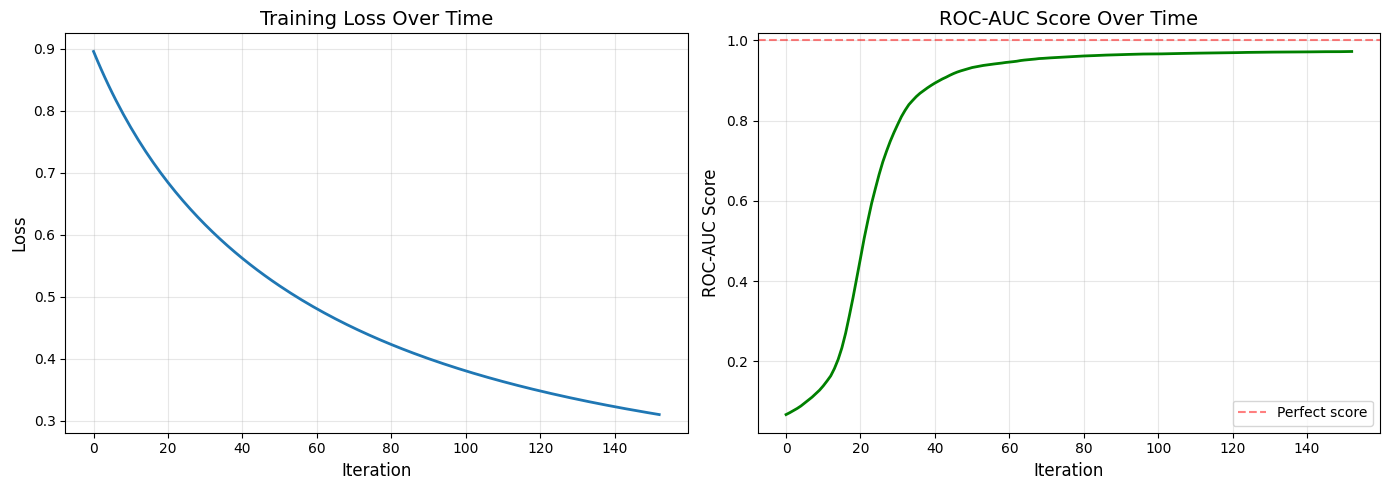

Loss decreased from 0.8953 to 0.3101
ROC-AUC improved from 0.0670 to 0.9725


In [12]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curve
axes[0].plot(losses, linewidth=2)
axes[0].set_xlabel("Iteration", fontsize=12)
axes[0].set_ylabel("Loss", fontsize=12)
axes[0].set_title("Training Loss Over Time", fontsize=14)
axes[0].grid(True, alpha=0.3)

# ROC-AUC curve
axes[1].plot(roc_auc_scores, linewidth=2, color="green")
axes[1].set_xlabel("Iteration", fontsize=12)
axes[1].set_ylabel("ROC-AUC Score", fontsize=12)
axes[1].set_title("ROC-AUC Score Over Time", fontsize=14)
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=1.0, color="r", linestyle="--", alpha=0.5, label="Perfect score")
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Loss decreased from {losses[0]:.4f} to {losses[-1]:.4f}")
print(f"ROC-AUC improved from {roc_auc_scores[0]:.4f} to {roc_auc_scores[-1]:.4f}")


### Evaluating on Test Data

The real test of our model is how well it performs on unseen data!


In [13]:
# Evaluate on test set
y_test_hat, _, _, _ = forward_propagation(
    X=X_test, W_1=W_1, b_1=b_1, W_2=W_2, b_2=b_2
)
test_roc_auc = roc_auc_score(y_true=y_test, y_score=y_test_hat)

print(f"Test Set Performance:")
print(f"  ROC-AUC Score: {test_roc_auc:.4f}")
print(f"\nThis indicates {'excellent' if test_roc_auc > 0.95 else 'good' if test_roc_auc > 0.85 else 'moderate'} performance!")

# Compare train vs test
print(f"\nTrain ROC-AUC: {roc_auc_scores[-1]:.4f}")
print(f"Test ROC-AUC:  {test_roc_auc:.4f}")
print(f"Difference:    {abs(roc_auc_scores[-1] - test_roc_auc):.4f}")

if abs(roc_auc_scores[-1] - test_roc_auc) < 0.05:
    print("✓ Good generalization - train and test performance are similar")
else:
    print("⚠ Possible overfitting - significant gap between train and test performance")


Test Set Performance:
  ROC-AUC Score: 0.9905

This indicates excellent performance!

Train ROC-AUC: 0.9725
Test ROC-AUC:  0.9905
Difference:    0.0180
✓ Good generalization - train and test performance are similar


## Building the Same Network in PyTorch

While implementing neural networks from scratch is educational, modern deep learning frameworks like **PyTorch** make it much easier to build, train, and deploy neural networks.

### Why PyTorch?

- **Automatic differentiation**: No need to manually derive and code backpropagation
- **GPU acceleration**: Easily train on GPUs for faster computation
- **Rich ecosystem**: Pre-built layers, optimizers, and tools
- **Industry standard**: Widely used in research and production

Let's rebuild our 2-layer network using PyTorch!


In [20]:
# Import PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


### Defining the Neural Network Architecture

In PyTorch, we define a network by subclassing `nn.Module` and specifying the layers in `__init__` and the forward pass in `forward`.


In [15]:
class TwoLayerNN(nn.Module):
    """A 2-layer neural network for binary classification.

    Architecture:
        Input -> Hidden Layer (3 neurons, sigmoid) -> Output Layer (1 neuron, sigmoid)
    """

    def __init__(self, input_size: int, hidden_size: int):
        """Initializes the network layers.

        Args:
            input_size: Number of input features.
            hidden_size: Number of neurons in the hidden layer.
        """
        super(TwoLayerNN, self).__init__()

        # Define layers
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Performs forward propagation.

        Args:
            x: Input tensor of shape (batch_size, input_size).

        Returns:
            Output predictions of shape (batch_size, 1).
        """
        # Hidden layer: linear transformation + sigmoid activation
        hidden_out = self.sigmoid(self.hidden(x))

        # Output layer: linear transformation + sigmoid activation
        output = self.sigmoid(self.output(hidden_out))

        return output


# Create the model
input_size = X.shape[1]  # 10 features
hidden_size = 3  # 3 hidden neurons

model = TwoLayerNN(input_size=input_size, hidden_size=hidden_size).to(device)

print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")


TwoLayerNN(
  (hidden): Linear(in_features=10, out_features=3, bias=True)
  (output): Linear(in_features=3, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Total parameters: 37


### Preparing Data for PyTorch

PyTorch works with tensors (similar to NumPy arrays). We'll convert our data and create data loaders for batch processing.


In [16]:
# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.FloatTensor(X).to(device)
y_train_tensor = torch.FloatTensor(y).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)

# Create datasets and data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

print(f"Training batches: {len(train_loader)}")
print(f"Batch size: 32")
print(f"Samples per epoch: {len(train_dataset)}")


Training batches: 15
Batch size: 32
Samples per epoch: 455


### Training the PyTorch Model

We need to define:
1. **Loss function**: Binary cross-entropy loss
2. **Optimizer**: SGD (Stochastic Gradient Descent) or Adam
3. **Training loop**: Forward pass → compute loss → backward pass → update weights


In [17]:
# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.SGD(model.parameters(), lr=0.1)  # Stochastic Gradient Descent

# Training loop
num_epochs = 100
pytorch_losses = []
pytorch_roc_auc_scores = []

print("Training PyTorch model...")
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    # Iterate over batches
    for batch_X, batch_y in train_loader:
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(batch_X)

        # Compute loss
        loss = criterion(predictions, batch_y)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        epoch_loss += loss.item()

    # Average loss for the epoch
    avg_loss = epoch_loss / len(train_loader)
    pytorch_losses.append(avg_loss)

    # Compute ROC-AUC on full training set
    model.eval()
    with torch.no_grad():
        train_predictions = model(X_train_tensor)
        train_roc_auc = roc_auc_score(
            y_train_tensor.cpu().numpy(),
            train_predictions.cpu().numpy()
        )
        pytorch_roc_auc_scores.append(train_roc_auc)

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:3d}/{num_epochs}: Loss = {avg_loss:.6f}, ROC-AUC = {train_roc_auc:.6f}")

print(f"\nTraining completed!")
print(f"Final loss: {pytorch_losses[-1]:.6f}")
print(f"Final ROC-AUC: {pytorch_roc_auc_scores[-1]:.6f}")


Training PyTorch model...
Epoch  10/100: Loss = 0.330181, ROC-AUC = 0.979352
Epoch  20/100: Loss = 0.225870, ROC-AUC = 0.982642
Epoch  30/100: Loss = 0.181348, ROC-AUC = 0.983469
Epoch  40/100: Loss = 0.170079, ROC-AUC = 0.983986
Epoch  50/100: Loss = 0.157195, ROC-AUC = 0.984214
Epoch  60/100: Loss = 0.153266, ROC-AUC = 0.984442
Epoch  70/100: Loss = 0.172637, ROC-AUC = 0.984731
Epoch  80/100: Loss = 0.150247, ROC-AUC = 0.984835
Epoch  90/100: Loss = 0.144994, ROC-AUC = 0.985104
Epoch 100/100: Loss = 0.159110, ROC-AUC = 0.985207

Training completed!
Final loss: 0.159110
Final ROC-AUC: 0.985207


### Evaluating the PyTorch Model


In [18]:
# Evaluate on test set
model.eval()
with torch.no_grad():
    y_test_pred_pytorch = model(X_test_tensor)
    test_roc_auc_pytorch = roc_auc_score(
        y_test_tensor.cpu().numpy(),
        y_test_pred_pytorch.cpu().numpy()
    )

print(f"PyTorch Model - Test Set Performance:")
print(f"  ROC-AUC Score: {test_roc_auc_pytorch:.4f}")


PyTorch Model - Test Set Performance:
  ROC-AUC Score: 0.9928


### Comparing Manual Implementation vs PyTorch

Let's visualize and compare the training curves from both approaches.


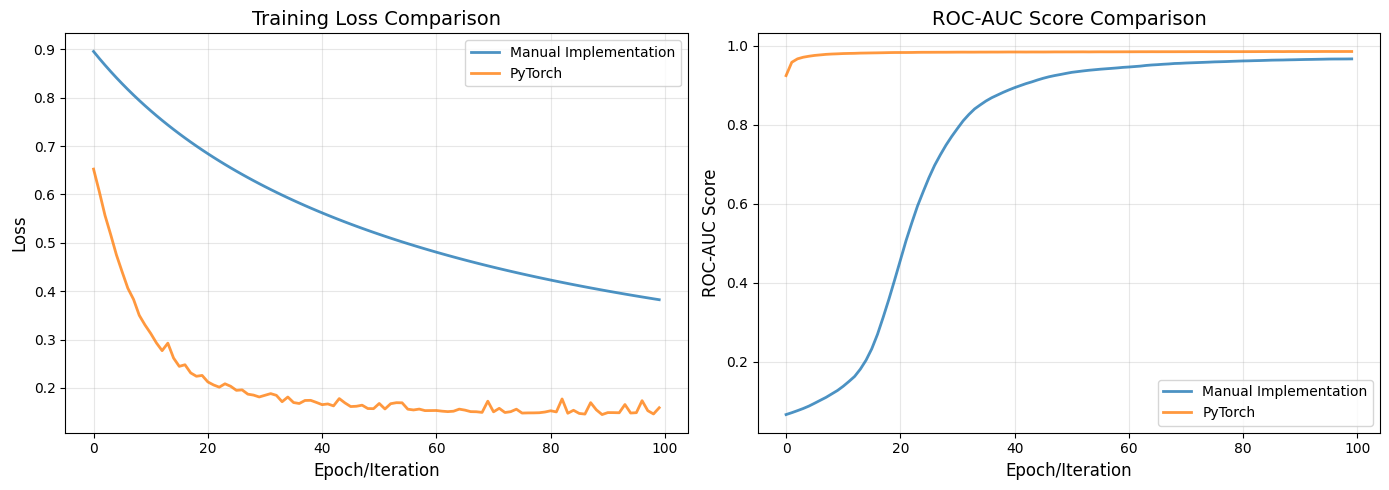


Final Comparison:
Method                    Test ROC-AUC   
Manual Implementation     0.9905
PyTorch                   0.9928

Both implementations achieve similar performance!


In [19]:
# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss comparison
axes[0].plot(losses[:100], label="Manual Implementation", linewidth=2, alpha=0.8)
axes[0].plot(pytorch_losses, label="PyTorch", linewidth=2, alpha=0.8)
axes[0].set_xlabel("Epoch/Iteration", fontsize=12)
axes[0].set_ylabel("Loss", fontsize=12)
axes[0].set_title("Training Loss Comparison", fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# ROC-AUC comparison
axes[1].plot(roc_auc_scores[:100], label="Manual Implementation", linewidth=2, alpha=0.8)
axes[1].plot(pytorch_roc_auc_scores, label="PyTorch", linewidth=2, alpha=0.8)
axes[1].set_xlabel("Epoch/Iteration", fontsize=12)
axes[1].set_ylabel("ROC-AUC Score", fontsize=12)
axes[1].set_title("ROC-AUC Score Comparison", fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print comparison
print("\nFinal Comparison:")
print(f"{'Method':<25} {'Test ROC-AUC':<15}")
print("=" * 40)
print(f"{'Manual Implementation':<25} {test_roc_auc:.4f}")
print(f"{'PyTorch':<25} {test_roc_auc_pytorch:.4f}")
print(f"\nBoth implementations achieve similar performance!")


## Summary

In this notebook, we've covered:

1. **Backpropagation Theory**: Understanding how gradients flow backward through the network using the chain rule
2. **Manual Implementation**: Implementing backpropagation and gradient descent from scratch
3. **Training Process**: Iteratively updating weights to minimize loss and improve predictions
4. **PyTorch Implementation**: Building and training the same network using modern deep learning tools

### Key Takeaways

- **Backpropagation** efficiently computes gradients by applying the chain rule backward through the network
- **Gradient descent** uses these gradients to iteratively update parameters in the direction that reduces loss
- **Binary cross-entropy loss** is the standard loss function for binary classification
- **PyTorch** automates the backpropagation process and provides GPU acceleration and rich tools
- Both manual and PyTorch implementations achieve similar performance, validating our understanding

### Manual vs PyTorch: When to Use Each

**Manual Implementation** (almost never used):
- Educational purposes (understanding how things work)
- Research on novel architectures or training algorithms
- Full control over every detail

**PyTorch** (or other frameworks):
- Production systems (faster development, better maintenance)
- Complex architectures (automatic differentiation is invaluable)
- GPU acceleration (essential for large-scale problems)
- Industry best practices (optimized implementations)
